In [1]:
import perceval as pcvl
import numpy as np
from scipy.optimize import minimize
import scipy
import random
import perceval.components.unitary_components as comp

## Use the symbolic skin for display
from perceval.rendering.circuit import DisplayConfig, SymbSkin
from perceval.utils import StateVector
DisplayConfig.select_skin(SymbSkin)
import matplotlib.pyplot as plt

similarity_y = []

def plot_similarity_dict(data_dict):
    plt.figure(figsize=(10, 5))
    
    for key, value_list in data_dict.items():
        if not value_list:  # Skip empty lists
            continue
        plt.plot(range(1, len(value_list) + 1), value_list, marker='o', label=key)
    
    plt.title('Similarity')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()
def plot_similarity(values):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(values) + 1), values, marker='o')
    plt.title('Similarity')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()

def g_objective(theta_g,theta_d):
    """
    Accepts two 1D np arrays corresponding to generator and discriminator parameters and returns a measurement of distance between gen and target
    """
    theta_g = theta_g.tolist()
    theta_d = theta_d.tolist()

    init = pcvl.BasicState("|1, 0, 0, 0, 1, 0, 0, 0>") + pcvl.BasicState("|0, 1, 0, 0, 0, 1, 0, 0>") + pcvl.BasicState("|0, 0, 1, 0, 0, 0, 1, 0>") + pcvl.BasicState("|0, 0, 0, 1, 0, 0, 0, 1>")
    target = pcvl.BasicState("|1,0,0,0,0,1,0,0>")+pcvl.BasicState("|0,1,0,0,0,0,1,0>")+pcvl.BasicState("|0,0,1,0,0,0,0,1>")+pcvl.BasicState("|0,0,0,1,1,0,0,0>")

    generator = make_generator(theta_g)
    discriminator = make_discriminator(theta_d)

    # combine gen and discr into one circuit
    full = pcvl.Circuit(8).add(0, generator, merge=True).add(0, discriminator, merge=True)

    prob_init = measure(full, init) # measurement of generated state
    prob_target = measure(discriminator, target) # measurement of target state
    #print('evaluated',abs(prob_22_target - prob_22_init))

    return (abs(prob_init[5]-prob_target[5])) # compare generated and target states

def print_similarity(theta_g,theta_d):
    theta_g = theta_g.tolist()
    theta_d = theta_d.tolist()

    init = pcvl.BasicState("|1, 0, 0, 0, 1, 0, 0, 0>") + pcvl.BasicState("|0, 1, 0, 0, 0, 1, 0, 0>") + pcvl.BasicState("|0, 0, 1, 0, 0, 0, 1, 0>") + pcvl.BasicState("|0, 0, 0, 1, 0, 0, 0, 1>")
    target = pcvl.BasicState("|1,0,0,0,0,1,0,0>")+pcvl.BasicState("|0,1,0,0,0,0,1,0>")+pcvl.BasicState("|0,0,1,0,0,0,0,1>")+pcvl.BasicState("|0,0,0,1,1,0,0,0>")
    id = pcvl.Circuit(8)
    generator = make_generator(theta_g)
    prob_init = measure(generator, init) # measurement of generated state
    prob_target = measure(id,target)
    print('Generated state: ',prob_init,'\nTarget state: ',prob_target,'\nSimilarity: ',prob_init@prob_target.T)
    similarity_y.append(4*(prob_init@prob_target.T))

def print_generated_state(theta_g,theta_d):
    theta_g = theta_g.tolist()
    theta_d = theta_d.tolist()

    init = pcvl.BasicState("|1, 0, 0, 0, 1, 0, 0, 0>") + pcvl.BasicState("|0, 1, 0, 0, 0, 1, 0, 0>") + pcvl.BasicState("|0, 0, 1, 0, 0, 0, 1, 0>") + pcvl.BasicState("|0, 0, 0, 1, 0, 0, 0, 1>")
    target = pcvl.BasicState("|1,0,0,0,0,1,0,0>")+pcvl.BasicState("|0,1,0,0,0,0,1,0>")+pcvl.BasicState("|0,0,1,0,0,0,0,1>")+pcvl.BasicState("|0,0,0,1,1,0,0,0>")

    generator = make_generator(theta_g)
    discriminator = make_discriminator(theta_d)

    # combine gen and discr into one circuit
    full = pcvl.Circuit(8).add(0, generator, merge=True).add(0, discriminator, merge=True)
    id = pcvl.Circuit(8)
    backend = pcvl.BackendFactory.get_backend("SLOS")

    sim = pcvl.Simulator(backend)
    sim.set_circuit(generator)

    distr = sim.probs_svd(pcvl.SVDistribution(sim.evolve(init)))["results"]
    print('processed input: ','\n01: ',distr[pcvl.BasicState("|1,0,0,0,0,1,0,0>")],'\n12: ',distr[pcvl.BasicState("|0,1,0,0,0,0,1,0>")],'\n23: ',distr[pcvl.BasicState("|0,0,1,0,0,0,0,1>")],'\n30: ',distr[pcvl.BasicState("|0,0,0,1,1,0,0,0>")])
    #print('|22>: ', distr[pcvl.BasicState("|0, 0, 1, 0, 0, 0, 1, 0>")])
    #sim.set_circuit(id)
    #distr = sim.probs_svd(pcvl.SVDistribution(sim.evolve(target)))["results"]
    #print('target: ',distr)
    #print('|22>: ', distr[pcvl.BasicState("|0, 0, 1, 0, 0, 0, 1, 0>")])

def measure(circuit, state):
    """
    Accepts a circuit and a state. Runs the state through the circuit & retrieves probability
    distribution, then returns the value for |2, 2>
    """
    ordered_basis = [pcvl.BasicState("|1, 0, 0, 0, 1, 0, 0, 0>"),
                     pcvl.BasicState("|1, 0, 0, 0, 0, 1, 0, 0>"),
                     pcvl.BasicState("|1, 0, 0, 0, 0, 0, 1, 0>"),
                     pcvl.BasicState("|1, 0, 0, 0, 0, 0, 0, 1>"),
                     pcvl.BasicState("|0, 1, 0, 0, 1, 0, 0, 0>"),
                     pcvl.BasicState("|0, 1, 0, 0, 0, 1, 0, 0>"),
                     pcvl.BasicState("|0, 1, 0, 0, 0, 0, 1, 0>"),
                     pcvl.BasicState("|0, 1, 0, 0, 0, 0, 0, 1>"),
                     pcvl.BasicState("|0, 0, 1, 0, 1, 0, 0, 0>"),
                     pcvl.BasicState("|0, 0, 1, 0, 0, 1, 0, 0>"),
                     pcvl.BasicState("|0, 0, 1, 0, 0, 0, 1, 0>"),
                     pcvl.BasicState("|0, 0, 1, 0, 0, 0, 0, 1>"),
                     pcvl.BasicState("|0, 0, 0, 1, 1, 0, 0, 0>"),
                     pcvl.BasicState("|0, 0, 0, 1, 0, 1, 0, 0>"),
                     pcvl.BasicState("|0, 0, 0, 1, 0, 0, 1, 0>"),
                     pcvl.BasicState("|0, 0, 0, 1, 0, 0, 0, 1>"),
                     ]
    backend = pcvl.BackendFactory.get_backend("SLOS")

    sim = pcvl.Simulator(backend)
    sim.set_circuit(circuit)

    distr = sim.probs_svd(pcvl.SVDistribution(sim.evolve(state)))["results"]
    return np.array([distr[state] for state in ordered_basis])


def make_generator(Phi_list): #Phi_list is a list of 30 values for the Phase Shifter parameters
    """
    Takes in list of angles. Returns the generator as a Circuit.
    """
    generator = pcvl.Circuit(8)
    BS = comp.BS()

    #next apply Phase shifters on to qubits 1-3, 0 index
    ps1 = comp.PS(phi = Phi_list[0]) # these may have to be variables and change
    ps2 = comp.PS(phi = Phi_list[1])
    ps3 = comp.PS(phi = Phi_list[2])
    generator.add(1, ps1) #add to second qubit
    generator.add(2, ps2)
    generator.add(3, ps3)

    # next is a beam splitter, or matrix applied to bits 1 and 2
    bs_1 = comp.BS() #not sure which matrix
    generator.add(1, bs_1)

    # after is another step of rotating
    ps4 = comp.PS(phi = Phi_list[3])
    generator.add(1, ps4)
    # then another beam splitter
    bs_2 = comp.BS() #again not sure which matrix
    generator.add(1, bs_2)
    bs_3 = comp.BS()
    generator.add(0, bs_3)
    bs_4 = comp.BS()
    generator.add(2, bs_4)

    #next is Phase shifters for qubits 0 and 2
    ps5 = comp.PS(phi = Phi_list[4])
    ps6 = comp.PS(phi = Phi_list[5])
    generator.add(0, ps5)
    generator.add(2, ps6)
    #then beam splitters for 0 and 2
    bs_5 = comp.BS()
    bs_6 = comp.BS()
    generator.add(0, bs_5)
    generator.add(2, bs_6)
    #next step one PS on 1
    ps7 = comp.PS(phi = Phi_list[6])
    generator.add(1, ps7)
    #then BS on 1
    bs_7  = comp.BS()
    generator.add(1, bs_7)
    #then PS on 1
    ps8 = comp.PS(phi = Phi_list[7])
    generator.add(1, ps8)
    #then BS on 1
    bs_8 = comp.BS()
    generator.add(1, bs_8)
    #then PS 0 and 2
    ps9 = comp.PS(phi = Phi_list[8])
    ps10 = comp.PS(phi = Phi_list[9])
    generator.add(0, ps9)
    generator.add(2, ps10)
    #then BS on 0 and 2
    bs_9 = comp.BS()
    bs_10 = comp.BS()
    generator.add(0, bs_9)
    generator.add(2, bs_10)
    #then PS 0 and 2
    ps11 = comp.PS(phi = Phi_list[10])
    ps12 = comp.PS(phi = Phi_list[11])
    generator.add(0, ps11)
    generator.add(2, ps12)
    #then BS on 0 and 2
    bs_11 = comp.BS()
    bs_12 = comp.BS()
    generator.add(0, bs_11)
    generator.add(2, bs_12)
    #then last is PS on 0-2
    ps13 = comp.PS(phi = Phi_list[12])
    ps14 = comp.PS(phi = Phi_list[13])
    ps15 = comp.PS(phi = Phi_list[14])
    generator.add(0, ps13)
    generator.add(1, ps14)
    generator.add(2, ps15)

    ### next layer
    generator.add(5, comp.PS(phi = Phi_list[15])) #add to second qubit
    generator.add(6, comp.PS(phi = Phi_list[16]))
    generator.add(7, comp.PS(phi = Phi_list[17]))

    # next is a beam splitter, or matrix applied to bits 1 and 2
    generator.add(5, comp.BS())

    # after is another step of rotating
    ps4 = comp.PS(phi = Phi_list[3])
    generator.add(5, comp.PS(phi = Phi_list[18]))
    # then another beam splitter
    generator.add(5, comp.BS())
    generator.add(4, BS)
    generator.add(6, BS)

    #next is Phase shifters for qubits 0 and 2
    generator.add(4, comp.PS(phi = Phi_list[19]))
    generator.add(6, comp.PS(phi = Phi_list[20]))
    #then beam splitters for 0 and 2

    generator.add(4, BS)
    generator.add(6, BS)
    #next step one PS on 1
    generator.add(5, comp.PS(phi = Phi_list[21]))
    #then BS on 1
    generator.add(5, BS)
    #then PS on 1
    generator.add(5, comp.PS(phi = Phi_list[22]))
    #then BS on 1
    generator.add(5, BS)
    #then PS 0 and 2
    ps9 = comp.PS(phi = Phi_list[8])
    ps10 = comp.PS(phi = Phi_list[9])
    generator.add(4, comp.PS(phi = Phi_list[23]))
    generator.add(6, comp.PS(phi = Phi_list[24]))
    #then BS on 0 and 2
    generator.add(4, BS)
    generator.add(6, BS)
    #then PS 0 and 2
    ps11 = comp.PS(phi = Phi_list[10])
    ps12 = comp.PS(phi = Phi_list[11])
    generator.add(4, comp.PS(phi = Phi_list[25]))
    generator.add(6, comp.PS(phi = Phi_list[26]))
    #then BS on 0 and 2
    generator.add(4, BS)
    generator.add(6, BS)
    #then last is PS on 0-2
    generator.add(4, comp.PS(phi = Phi_list[27]))
    generator.add(5, comp.PS(phi = Phi_list[28]))
    generator.add(6, comp.PS(phi = Phi_list[29]))

    return generator


def d_objective(theta_d,theta_g):
    """Accepts two 1D np arrays corresponding to discriminator and generator parameters and returns a negative measurement of distance between gen and target"""
    return -g_objective(theta_g, theta_d)

def cheat_objective(theta_g):
    backend = pcvl.BackendFactory.get_backend("SLOS")

    sim = pcvl.Simulator(backend)
    generator = make_generator(theta_g)
    sim.set_circuit(generator)
    init = pcvl.BasicState("|1, 0, 0, 0, 1, 0, 0, 0>") + pcvl.BasicState("|0, 1, 0, 0, 0, 1, 0, 0>") + pcvl.BasicState("|0, 0, 1, 0, 0, 0, 1, 0>") + pcvl.BasicState("|0, 0, 0, 1, 0, 0, 0, 1>")
    
    distr = sim.probs_svd(pcvl.SVDistribution(sim.evolve(init)))["results"]
    output = np.array([distr[pcvl.BasicState("|1,0,0,0,0,1,0,0>")],distr[pcvl.BasicState("|0,1,0,0,0,0,1,0>")],distr[pcvl.BasicState("|0,0,1,0,0,0,0,1>")],distr[pcvl.BasicState("|0,0,0,1,1,0,0,0>")]])
    loss = (output[0]-0.25)**2+(output[1]-0.25)**2+(output[2]-0.25)**2+(output[3]-0.25)**2
    return loss




def make_discriminator(phi_list):
    """
    Takes in list of angles. Returns the discriminator as a Circuit.
    """
    discriminator = pcvl.Circuit(8) # initialize circuit w/ 8 qubits

    # first column of gates: PS 0, 1, 2, 4, 5, 6
    discriminator.add(0, comp.PS(phi_list[0])).add(1, comp.PS(phi_list[1])).add(2, comp.PS(phi_list[2]))
    discriminator.add(4, comp.PS(phi_list[3])).add(5, comp.PS(phi_list[4])).add(6, comp.PS(phi_list[5]))

    # second column of gates: BS 0-1, 2-3, 4-5, 6-7
    discriminator.add((0, 1), comp.BS()).add((2,3), comp.BS())
    discriminator.add((4, 5), comp.BS()).add((6,7), comp.BS())

    # third column of gates: PS 0, 2, 4, 6
    discriminator.add(0, comp.PS(phi_list[6])).add(2, comp.PS(phi_list[7]))
    discriminator.add(4, comp.PS(phi_list[8])).add(6, comp.PS(phi_list[9]))

    # third column of gates: BS 0-1, 2-3, 4-5, 6-7
    discriminator.add((0, 1), comp.BS()).add((2,3), comp.BS())
    discriminator.add((4, 5), comp.BS()).add((6,7), comp.BS())

    # fourth column of gates: BS 1-2, 5-6
    discriminator.add((1, 2), comp.BS())
    discriminator.add((5, 6), comp.BS())

    # fifth column of gates: PS 1, 5
    discriminator.add(1, comp.PS(phi_list[10]))
    discriminator.add(5, comp.PS(phi_list[11]))

    return discriminator

# test with random values
# print(g_objective([0, 0, 0, 0.1, 0, 0, 0.3, 0, 0, 0, 0, 0, 0, 0, 0, 0.7, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0], [0, 0.2, 0, 0.5, 0, 0, 0, 0.8, 0, 0, 0.9, 0]))
def print_generated_state_cheat(theta_g):

    
    theta_g = theta_g.tolist()

    init = pcvl.BasicState("|1, 0, 0, 0, 1, 0, 0, 0>") + pcvl.BasicState("|0, 1, 0, 0, 0, 1, 0, 0>") + pcvl.BasicState("|0, 0, 1, 0, 0, 0, 1, 0>") + pcvl.BasicState("|0, 0, 0, 1, 0, 0, 0, 1>")
    target = pcvl.BasicState("|1,0,0,0,0,1,0,0>")+pcvl.BasicState("|0,1,0,0,0,0,1,0>")+pcvl.BasicState("|0,0,1,0,0,0,0,1>")+pcvl.BasicState("|0,0,0,1,1,0,0,0>")

    generator = make_generator(theta_g)
    
    backend = pcvl.BackendFactory.get_backend("SLOS")

    sim = pcvl.Simulator(backend)
    sim.set_circuit(generator)

    distr = sim.probs_svd(pcvl.SVDistribution(sim.evolve(init)))["results"]
    print('processed input: ','\n01: ',distr[pcvl.BasicState("|1,0,0,0,0,1,0,0>")],'\n12: ',distr[pcvl.BasicState("|0,1,0,0,0,0,1,0>")],'\n23: ',distr[pcvl.BasicState("|0,0,1,0,0,0,0,1>")],'\n30: ',distr[pcvl.BasicState("|0,0,0,1,1,0,0,0>")])

In [2]:
def approximate_gradient(f, x,arg, h=1e-5,num_grads = 5):
    """
    Approximate the gradient of the function f at point x using finite differences.

    :param f: The function for which the gradient is to be calculated. It should take a NumPy array and return a scalar.
    :param x: A (n) ndarray of inputs.
    :param h: A small value to use for computing finite differences.
    :return: A ndarray of the same size as x with the approximated gradients.
    """
    gradients = np.zeros_like(x)
    random_indices = [random.randrange(0, len(x[:])) for _ in range(num_grads)]
    for i in range(x.shape[0]):
        x_plus_h = np.copy(x)
        x_minus_h = np.copy(x)
        x_plus_h[i] += h
        x_minus_h[i] -= h
        f_plus_h = f(x_plus_h,arg)
        f_minus_h = f(x_minus_h,arg)
        gradients[i] = (f_plus_h - f_minus_h) / (2 * h)
    return gradients

def optimize(f,x, arg, minimize = True,step_size = 0.05):
    gradients = None
    niters = 0
    while type(gradients)==type(None) or np.linalg.norm(gradients)<=0.01 or niters<=10:
        gradients = approximate_gradient(f,x,arg)
        x = x-gradients*step_size
        niters+=1
    return x

In [ ]:
num_rounds = 200
theta_g, theta_d = (np.random.uniform(low = 0,high = 3.141,size = (30)), np.random.uniform(low = 0,high = 3.141,size = (12)))#(np.array([0, 0, 0, 0.1, 0, 0, 0.3, 0, 0, 0, 0, 0, 0, 0, 0, 0.7, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0]), np.array([0, 0.2, 0, 0.5, 0, 0, 0, 0.8, 0, 0, 0.9, 0]))
best_generator = minimize(cheat_objective, theta_g, method='nelder-mead', options={'xatol': 1e-8, 'disp': True,'maxiter':2000})
print(best_generator.fun)

In [ ]:
theta_g = best_generator.x
print_generated_state_cheat(theta_g)
print(best_generator.x)


In [3]:
num_rounds = 2000
theta_g, theta_d = (np.random.uniform(low = 0,high = 3.141,size = (30)), np.random.uniform(low = 0,high = 3.141,size = (12)))#(np.array([0, 0, 0, 0.1, 0, 0, 0.3, 0, 0, 0, 0, 0, 0, 0, 0, 0.7, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0]), np.array([0, 0.2, 0, 0.5, 0, 0, 0, 0.8, 0, 0, 0.9, 0]))
similarity_y=[]
og_list = []
od_list = []
for i in range(num_rounds):
    best_generator = optimize(g_objective,theta_g,theta_d)
    theta_g = best_generator
    print('g_objective: ',g_objective(theta_g,theta_d))
    og_list.append(g_objective(theta_g,theta_d))
    best_discriminator = optimize(d_objective,theta_d,theta_g)
    theta_d = best_discriminator
    
    print('d_objective: ',d_objective(theta_d,theta_g))
    od_list.append(-1*d_objective(theta_d,theta_g))
    print_similarity(theta_g,theta_d)
    series_dict = {'Similarity':similarity_y,'Generator objective':og_list,'Discriminator objective':od_list}
    plot_similarity_dict(series_dict)
    

g_objective:  0.04047755308179181
d_objective:  -0.22350198777422234
Generated state:  [0.04253334 0.09177443 0.03726574 0.07842649 0.03544419 0.0644088
 0.09526567 0.05488134 0.05247377 0.04421512 0.07517884 0.07813227
 0.1195487  0.04960164 0.04228975 0.03855991] 
Target state:  [0.   0.25 0.   0.   0.   0.   0.25 0.   0.   0.   0.   0.25 0.25 0.
 0.   0.  ] 
Similarity:  0.09618026696480564


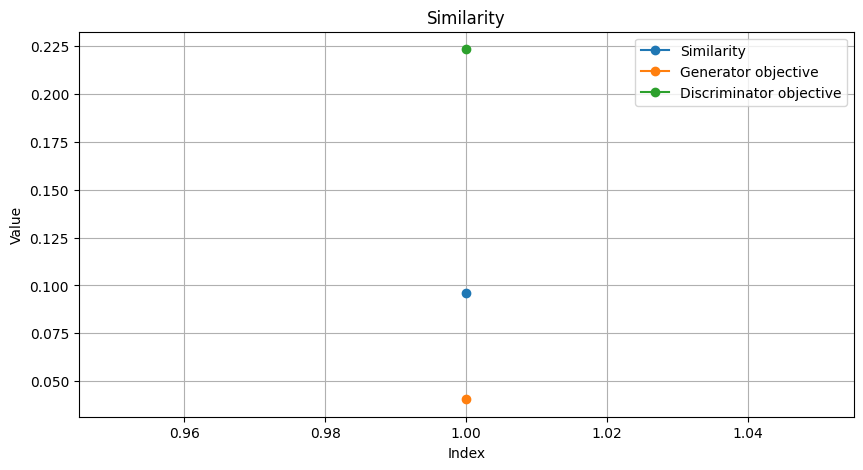

g_objective:  0.13436777938992586
d_objective:  -0.20029551970610257
Generated state:  [0.03337399 0.06736472 0.04026446 0.10899682 0.07199648 0.0627301
 0.08902794 0.02624548 0.05566857 0.04989364 0.08392215 0.06051564
 0.08896095 0.07001154 0.03678545 0.05424205] 
Target state:  [0.   0.25 0.   0.   0.   0.   0.25 0.   0.   0.   0.   0.25 0.25 0.
 0.   0.  ] 
Similarity:  0.07646731165807681


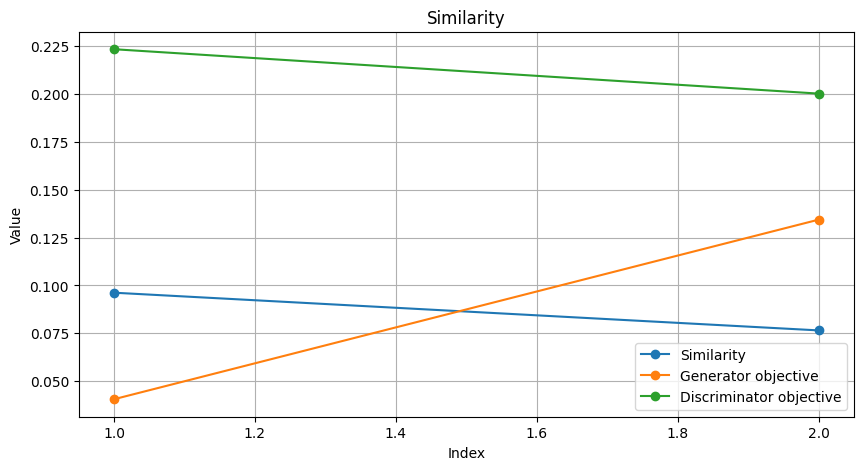

g_objective:  0.13896990823673044
d_objective:  -0.19132410363518834
Generated state:  [0.02851996 0.0552127  0.04057896 0.12568838 0.10509367 0.04368497
 0.09314158 0.00807978 0.06805576 0.08155617 0.07675178 0.02363629
 0.04833061 0.06954616 0.03952767 0.09259556] 
Target state:  [0.   0.25 0.   0.   0.   0.   0.25 0.   0.   0.   0.   0.25 0.25 0.
 0.   0.  ] 
Similarity:  0.05508029609142128


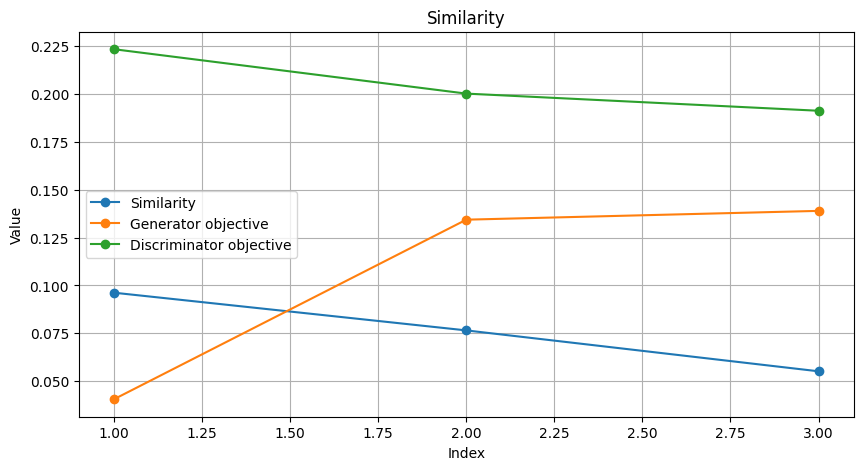

g_objective:  0.12238806136867122
d_objective:  -0.17053441259422042
Generated state:  [0.03444687 0.05668753 0.03369641 0.1251692  0.08942597 0.06214922
 0.0958863  0.00253851 0.08365863 0.0912024  0.07084051 0.00429845
 0.04246853 0.03996085 0.04957678 0.11799384] 
Target state:  [0.   0.25 0.   0.   0.   0.   0.25 0.   0.   0.   0.   0.25 0.25 0.
 0.   0.  ] 
Similarity:  0.049835202381283444


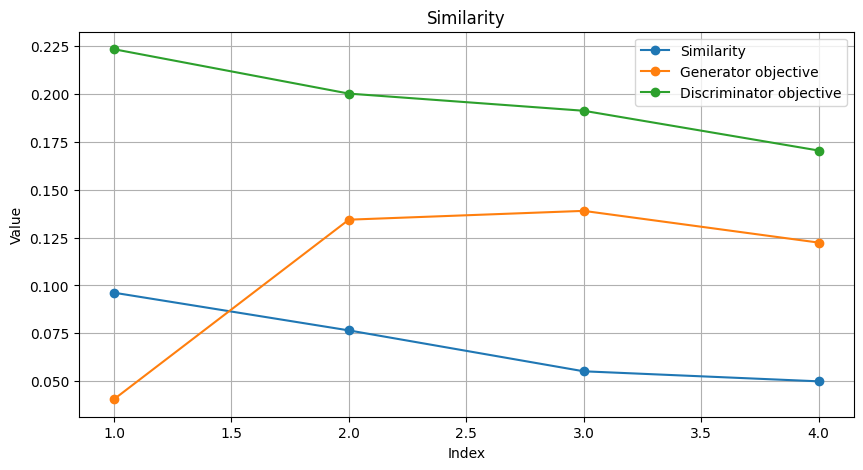

g_objective:  0.1002531162700179
d_objective:  -0.14167046429846902
Generated state:  [7.58154034e-02 3.16581782e-02 2.97096482e-02 1.12816770e-01
 9.52977652e-02 4.45736534e-02 9.50998653e-02 1.50287161e-02
 4.84498343e-02 1.14186710e-01 8.73555473e-02 7.90876984e-06
 3.04369970e-02 5.95814587e-02 3.78349393e-02 1.22146605e-01] 
Target state:  [0.   0.25 0.   0.   0.   0.   0.25 0.   0.   0.   0.   0.25 0.25 0.
 0.   0.  ] 
Similarity:  0.03930073731814143


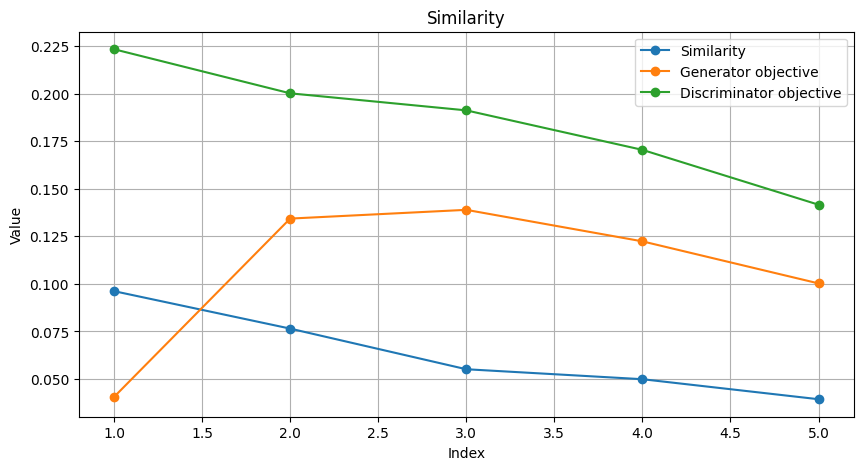

g_objective:  0.06622206462854484
d_objective:  -0.153081269987304
Generated state:  [0.1113311  0.00733074 0.02629927 0.10503889 0.06596206 0.06840596
 0.08178133 0.03385065 0.02847704 0.11533514 0.10584558 0.00034225
 0.04422981 0.05892817 0.03607382 0.11076821] 
Target state:  [0.   0.25 0.   0.   0.   0.   0.25 0.   0.   0.   0.   0.25 0.25 0.
 0.   0.  ] 
Similarity:  0.033421031785442465


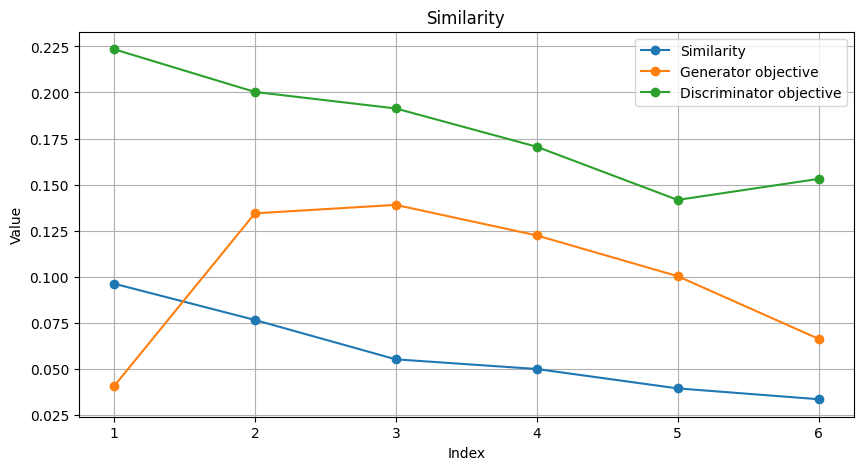

g_objective:  0.0802370202066526


KeyboardInterrupt: 

In [2]:
num_rounds = 2000
theta_g, theta_d = (np.random.uniform(low = 0,high = 3.141,size = (30)), np.random.uniform(low = 0,high = 3.141,size = (12)))#(np.array([0, 0, 0, 0.1, 0, 0, 0.3, 0, 0, 0, 0, 0, 0, 0, 0, 0.7, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0]), np.array([0, 0.2, 0, 0.5, 0, 0, 0, 0.8, 0, 0, 0.9, 0]))
og_list = []
od_list = []
for i in range(num_rounds):
    best_generator = minimize(g_objective, theta_g, method='nelder-mead', args = (theta_d), options={'maxiter':100})
    theta_g = best_generator.x
    print('g_objective: ',best_generator.fun)
    og_list.append(best_generator.fun)
    best_discriminator = minimize(d_objective, theta_d, method='nelder-mead', args = (theta_g), options={'maxiter':100})
    theta_d = best_discriminator.x
    
    print('d_objective: ',best_discriminator.fun)
    od_list.append(-1*best_discriminator.fun)
    print_similarity(theta_g,theta_d)
    series_dict = {'Similarity':similarity_y,'Generator objective':og_list,'Discriminator objective':od_list}
    plot_similarity_dict(series_dict)
    